In [1]:
include("so5.jl");

using Plots, Interpolations, LaTeXStrings

# fnt = Plots.font("sans-serif")
# default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

Plots.scalefontsizes()
Plots.scalefontsizes(1.5)
pyplot()
# PyPlot.rc("font", family="Times")

using JLD2
using FileIO
;

In [2]:
intlist = [(57,106,177), (218,124,48), (62,150,81), (204,37,41), (83,81,84), (107,76,154), (146,36,40), (148,139,61)]
colorlist = [RGBA(r/255,g/255,b/255,1) for (r,g,b) in intlist]
;

In [3]:
f1 = "itp_colored.jld2"
f2 = "itp_uncolored.jld2"

@assert load(f1, "kR_list") == load(f2, "kR_list") "kR_list is different!"
itp = load(f1, "itp")
kR_list = load(f1, "kR_list")
itp_uncolored = load(f2, "itp")
af_list = itp[3]["af"]

@show kR_list
@show keys(itp[3])
;

kR_list = [1.5, 2.0, 2.5, 3.0]
keys(itp[3]) = ["zR", "minphi", "higgsmass", "ctop", "cT", "aL", "aB", "af"]


### Plot `itp`

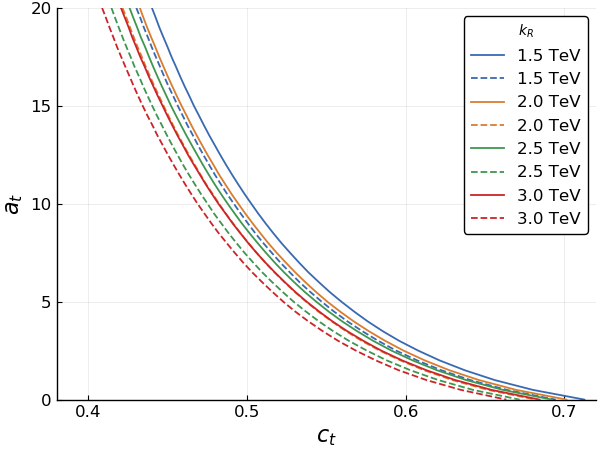

In [4]:
fig = plot(ylim = (0,20), xlim = (0.38, 0.72), 
            xlabel = L"c_{t}", ylabel = L"a_t", 
            legendtitle = L"k_R", size = (600,450)
)
# lcolor = [:red :green :blue :purple]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["af"], linewidth = 1.3, linecolor = colorlist[i], label = "$kR TeV")
    plot!(fig, itp_uncolored[kR]["ctop"], itp[kR]["af"], linewidth = 1.3, linecolor = colorlist[i], label = "$kR TeV", linestyle = :dash)
end
fig

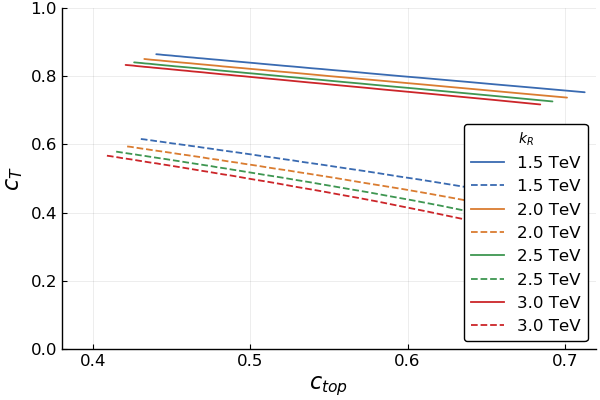

In [5]:
fig = plot(ylim = (0,1), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"c_T", legendtitle = L"k_R")
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["cT"], label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig, itp_uncolored[kR]["ctop"], itp_uncolored[kR]["cT"], label = "$kR TeV", 
                linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
end
fig

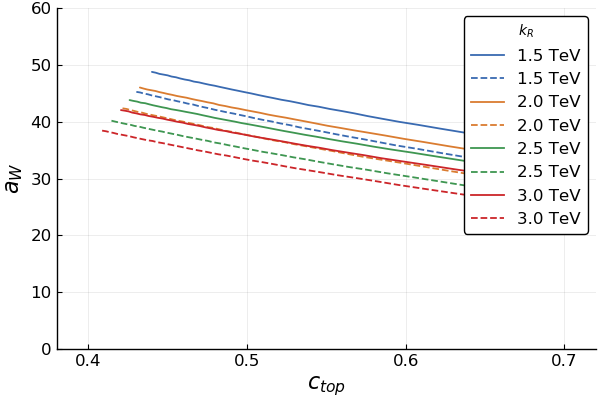

In [6]:
fig = plot(ylim = (0,60), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"a_W", legendtitle = L"k_R")
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["aL"], label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig, itp_uncolored[kR]["ctop"], itp_uncolored[kR]["aL"], label = "$kR TeV", 
            linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
end
fig

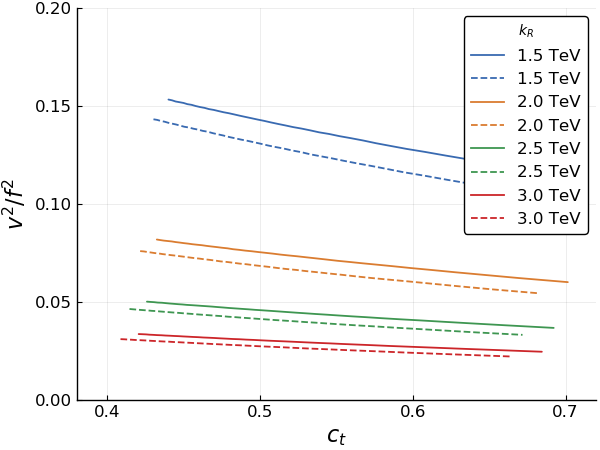

In [7]:
fig = plot(ylim = (0,0.2), xlim = (0.38, 0.72), 
    yticks = (0:0.05:0.2),
    xlabel = L"c_{t}", ylabel = L"v^2/f^2",
    legend = :topright, legendtitle = L"k_R",
    size = (600,450)
)
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], sin.(2*itp[kR]["minphi"]).^2, label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig, itp_uncolored[kR]["ctop"], sin.(2*itp_uncolored[kR]["minphi"]).^2, label = "$kR TeV", 
                linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
end
fig

In [8]:
for (i, kR) in enumerate(kR_list)
    itp[kR]["mT"] = [pmmass(cT, 1. /kR ; n=1)[1] for cT in itp[kR]["cT"]]
    itp_uncolored[kR]["mT"] = [pmmass(cT, 1. /kR ; n=1)[1] for cT in itp_uncolored[kR]["cT"]]
end

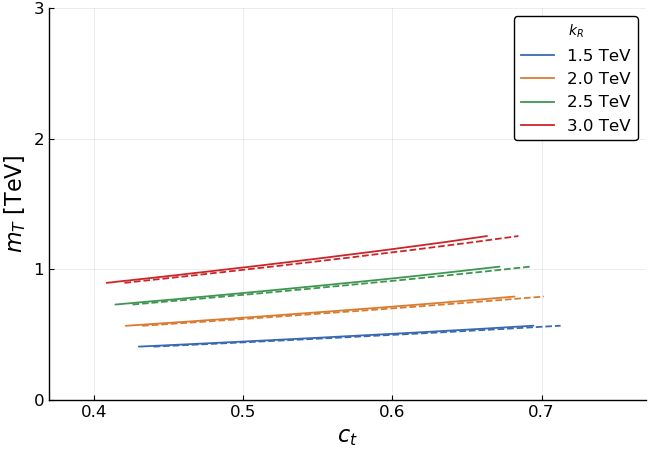

In [9]:
fig = plot(ylim = (0,3), xlim = (0.37, 0.77), 
    xlabel = L"c_{t}", ylabel = L"$m_T$ [TeV]", 
    legendtitle = L"k_R", legend = :topright, size = (650,450)
)
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp_uncolored[kR]["ctop"],  itp[kR]["mT"], label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig, itp[kR]["ctop"],  itp[kR]["mT"], label = "", 
                linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
end
# annotate!(0.7,0.5,"colored")
fig

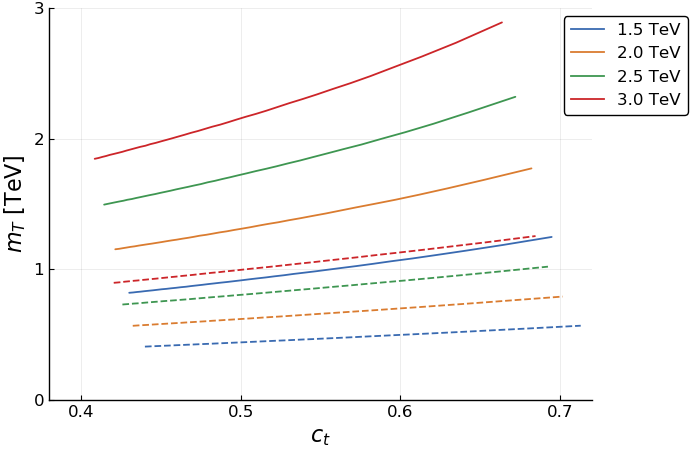

In [10]:
l = @layout [b c{0.15w}]

fig1 = plot(ylim = (0,3), xlim = (0.38, 0.72), 
    xlabel = L"c_{t}", ylabel = L"$m_T$ [TeV]", 
    legendtitle = L"k_R", legend = :none, size = (650,450)
)
fig2 = plot(grid = false, xlims=(100,1), showaxis=false)
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig1, itp_uncolored[kR]["ctop"],  itp_uncolored[kR]["mT"], label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig1, itp[kR]["ctop"],  itp[kR]["mT"], label = "", 
                linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
    plot!(fig2, itp_uncolored[kR]["ctop"],  itp_uncolored[kR]["mT"], label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
end

fig = plot(fig1, fig2, layout=l)
plot!(fig, size=(700,450))
fig

### Find the line of phase transition

#### from the `data`

In [11]:
function cT_of_phase_transition(arg::Params)
    function total_A(cT::Float64)
        arg.cvar = cT
        attractive = -2*3*approx_A(arg, top_denom) + 3*approx_A(arg, W_denom) + 3/2*approx_A(arg, Z_denom)
        repulsive = 2*3*approx_A(arg, repulsive_denom)
        return attractive + repulsive
    end
    return nsolve(total_A, 0. ; lower = 0., upper = 1.)
end

function cT_of_phase_transition_uncolored(arg::Params)
    function total_A(cT::Float64)
        arg.cvar = cT
        attractive = -2*3*approx_A(arg, top_denom) + 3*approx_A(arg, W_denom) + 3/2*approx_A(arg, Z_denom)
        repulsive = 2*approx_A(arg, repulsive_denom)
        return attractive + repulsive
    end
    return nsolve(total_A, 0. ; lower = 0., upper = 1.)
end
;

In [12]:
# helper function to map from itp to Params

function dict_to_Params(dict, idx)
    arg = Params(0.,0.,0.,0.,0.,0.,0.,0.,0.,false)
    arg.aL     = dict["aL"][idx]
    arg.aB     = dict["aB"][idx]
    arg.af     = dict["af"][idx]
    arg.zR     = dict["zR"][idx]
    arg.mh     = dict["higgsmass"][idx]
    arg.ctop   = dict["ctop"][idx]
    arg.cvar   = dict["cT"][idx]
    arg.minphi = dict["minphi"][idx]
    return arg
end
;  

In [13]:
for kR in kR_list
    cT = zeros(length(af_list))
    cT_uncolored = zeros(length(af_list))
    for idx = 1:length(cT)
        arg = dict_to_Params(itp[kR], idx)
        cT[idx] = cT_of_phase_transition(arg)
        arg = dict_to_Params(itp_uncolored[kR], idx)
        cT_uncolored[idx] = cT_of_phase_transition_uncolored(arg)
    end
    itp[kR]["criticalcT"] = cT 
    itp_uncolored[kR]["criticalcT"] = cT_uncolored 
end
;

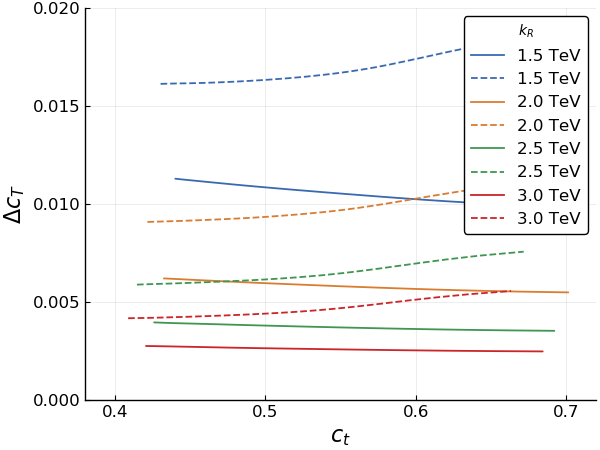

In [14]:
fig = plot(ylim = (0.,0.02), xlim = (0.38, 0.72), 
    xlabel = L"c_{t}", ylabel = L"\Delta c_T", 
    legendtitle = L"k_R", size = (600,450))
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"],  smooth(itp[kR]["cT"] - itp[kR]["criticalcT"]; win_len = 19), 
        label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i])
    plot!(fig, itp_uncolored[kR]["ctop"],  smooth(itp_uncolored[kR]["cT"] - itp_uncolored[kR]["criticalcT"]; win_len = 19), 
        label = "$kR TeV", linewidth = 1.3, linecolor = colorlist[i], linestyle = :dash)
end
fig